# Data and Analysis Plan: Air Quality and Public Health
- Sarah Abouchleih
- Kaydence Lin
- Rishpiath Satter

## Introduction and Data Description

## Abstract

This project explores the connections between air quality, healthcare spending, and the prevalence of Chronic Obstructive Pulmonary Disease (COPD) across U.S. states. We used air quality data obtained from wisevoter.com and the openaq API, along with healthcare spending and COPD prevalence data from the CDC and GHDE. A comprehensive dataset is created, encompassing good, moderate, and unhealthy air quality days, average COPD prevalence, and healthcare spending per capita for each U.S. state. Our project leverages a multiple linear regression model to interpret air quality metrics and predict potential healthcare costs, and our findings revealed that states with better air quality tend to exhibit lower COPD prevalence rates and spend less on healthcare. Specifically, a one-unit increase in the percentage of good air quality days corresponds to a 10.04% reduction in COPD prevalence, while the same increase in moderate and unhealthy days correlates with decreases of 7.9% and 3.30%. In healthcare spending, an increase in the percentage of good, moderate, and unhealthy air quality days corresponds to decreases of $8393.06, $7655.86, and $1924.53.  



## Project Goal:

Air quality is a crucial factor affecting public health and well-being. Poor air quality, characterized by high levels of pollutants, can lead to various health issues, including respiratory diseases, cardiovascular problems, and even premature death. This project aims to investigate the impact of air quality on public health within the US and explore potential insights that data science can provide. We ask:

- Is there a significant correlation between air quality and healthcare costs between different states in the US?

- Is there a significant correlation between air quality and the prevalence of COPD?

We are webscrapping Air Quality Index (AQI) data from https://wisevoter.com/state-rankings/air-quality-by-state/ and getting data from the openaq API https://openaq.org/. We are also utilizing data and csv's from the CDC and Global Health Data Exchange (GHDE).

#### For Air Quality Webscraping

- The scrape_aqi(url) function sends an HTTP GET request to the URL to retrieve Air Quality Index
- It uses BeautifulSoup to parse the HTML content, extracts AQI data from a table, and organizes it into DF
- The resulting DataFrame is saved to a CSV file, providing a structured dataset for future data analysis.



#### For OpenAQ API  

Note: We didn't end up using it but if we decide to continue researching air quality within different regions its a good source to use

- The openaq_api(url) function requests the airquality data from openaq api
- extracting information on countries and their corresponding air quality measurements.
- The function transforms this data into a Pandas DataFrame, making data access easy


#### COPD Data from CSV:

- The csv_copd(csv) function takes CSV file as input and reads into a Dataframe
- The function filters df to include 'Public_Health_Jurisdiction' and 'Percent_COPD'
- Calculates the average percent COPD by state and groups the data

#### For Health Spending CSV extraction
- csv_spending(csv) reads the health spending data from a CSV file into a Dataframe
- Filter rows based on conditions: 'metric' should be 'Spending per capita', etc
- Extract specific columns from the filtered DataFrame: 'state' and 'val'.

## Pipeline Overview:

### Webscrape AQI Data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from itertools import zip_longest
# https://www.geeksforgeeks.org/python-itertools-zip_longest/

def scrape_aqi(url):
    ''' webscrapes AQI data
    Args:
        url: url of the website we want to scrape AQI data from

    Returns:
        dataframe: dataframe of state and percentage of different AQi data
    '''

    # get response
    response = requests.get(url)

    if response.status_code == 200:
        # use BeautifulSoup to get data from tables
        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table')
        headers = [header.text.strip() for header in table.find('tr').find_all('th')]

        # create list to store data
        data = {header: [] for header in headers}

        # get data for every row in tables
        for row in table.find_all('tr')[1:]:  # Skip the header row
            row_data = [cell.text.strip() for cell in row.find_all('td')]

            # see if arrays have the same length with zip_longest
            for header, cell_data in zip_longest(headers, row_data, fillvalue=None):
                data[header].append(cell_data)

        # create dataframe and save to csv to make future data analysis easier
        df = pd.DataFrame(data)
        df.to_csv('air_quality_data.csv', index=False)

    else:
        print(f"Failed to retrieve the web page. Status code: {response.status_code}")

    return df

In [2]:
url = 'https://wisevoter.com/state-rankings/air-quality-by-state/'
scrape_aqi(url).head()

,#,State,Good Air Quality Days,Moderate Air Quality Days,Unhealthy Air Quality Days
0,1,Hawaii,99.4%,0.6%,0%
1,2,Maine,93.2%,6.3%,0.5%
2,3,Alaska,92.3%,6.4%,1.3%
3,4,Virginia,91.5%,8.4%,0.2%
4,5,Vermont,91.3%,8.5%,0.2%


### Get Data From OpenAQ API

In [3]:
import requests

def openaq_api(url):
    ''' gets AQI data from OpenAQ API
    Args:
        url: url we want to use to get data from

    Returns:
        dataframe: dataframe of country and air quality measurements
    '''
    # get responses
    headers = {
        "accept": "application/json",
        "content-type": "application/json"
    }
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # get data in json dictionary
        data = response.json()
        countries = data['results']
        country_lst = []

        # get AQI data for each country
        for country in countries:
            country_data = {
                "Country": country['name'],
                "Air Quality Measurements": country['count']
            }
            country_lst.append(country_data)

        # create dataframe from country_lst
        df = pd.DataFrame(country_lst)

    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")

    return df

In [4]:
url = "https://api.openaq.org/v2/countries?limit=100&page=1&offset=0&sort=asc&order_by=name"
openaq_api(url).head()

,Country,Air Quality Measurements
0,Afghanistan,1920228
1,Algeria,34972
2,Angola,2232354
3,Antarctica,9180
4,Argentina,4194535


### Percent of COPD based on each state
https://www.cdc.gov/copd/data-and-statistics/state-estimates.html

In [5]:
import pandas as pd

state_mapping = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'}

def csv_copd(csv):
    ''' read COPD data from a csv into a dataframe
    Args:
        csv: name of the csv

    Returns:
        df: dataframe of the data from csv
    '''
    # read csv into df
    df = pd.read_csv(csv)
    df = df[['Public_Health_Jurisdiction', 'Percent_COPD']]

    # Clean state names using the mapping dictionary
    df['Public_Health_Jurisdiction'] = df['Public_Health_Jurisdiction'].map(state_mapping)

    # Group by state and calculate the average percent COPD
    result = df.groupby('Public_Health_Jurisdiction')['Percent_COPD'].mean().reset_index()
    result.columns = ['State', 'Average_Percent_COPD']

    return result


In [6]:
csv = 'County_COPD_prevalence.csv'
csv_copd(csv).head()

,State,Average_Percent_COPD
0,Alabama,8.871642
1,Alaska,7.048276
2,Arizona,6.946667
3,Arkansas,9.001333
4,California,5.437931


### Health Spendings in Diff States
https://ghdx.healthdata.org/record/ihme-data/united-states-health-spending-by-state-payer-type-service-2003-2019

In [7]:
import pandas as pd

def csv_spending(csv):
    ''' read health spending data from a csv into a dataframe
    Args:
        csv: name of the csv

    Returns:
        df: dataframe of the data from csv
    '''
    # read csv into dataframe
    df = pd.read_csv("health_spendings.csv")

    # get spendings from 2019
    df = df[(df['metric'] == 'Spending per capita') & (df['subgroup'] == 'Total') & (df['year'] == 2019)]
    df = df[['state', 'val']]

    return df

In [8]:
csv = 'health_spendings.csv'
csv_spending(csv).head()

,state,val
13480,Illinois,9976
13498,Indiana,10347
13516,Michigan,9737
13534,Ohio,10408
13552,Wisconsin,10444


### Merge Data into One Dataframe

In [9]:
import pandas as pd

def merge_data(csv1, csv2, csv3):
    '''merges three csv's into one dataframe
    Args:
        csv1 (csv): air aquality data csv from API
        csv2 (csv): COPD csv
        csv3 (csv): health spendings csv

    Returns:
        df: dataframe of the merged data from the CSV's
    '''
    # merge dataframes
    merged_df = pd.merge(df_aqi, df_copd, on = 'State', how = 'left')
    merged_df = pd.merge(merged_df, df_spending, left_on = 'State', right_on = 'state', how = 'left')
    merged_df.drop('state', axis = 1, inplace = True)

    # convert percentages into decimal
    merged_df['Good AQ Days'] = pd.to_numeric(merged_df['Good Air Quality Days'].str.replace('%', ''), errors='coerce') / 100
    merged_df['Moderate AQ Days'] = pd.to_numeric(merged_df['Moderate Air Quality Days'].str.replace('%', ''), errors='coerce') / 100
    merged_df['Unhealthy AQ Days'] = pd.to_numeric(merged_df['Unhealthy Air Quality Days'].str.replace('%', ''), errors='coerce') / 100
    merged_df['Average_COPD'] = pd.to_numeric(merged_df['Average_Percent_COPD']) / 100

    # rename val column
    merged_df.rename(columns = {'val' : 'Health Spendings ($)'}, inplace=True)

    return merged_df

In [10]:
# get datasets
df_aqi = pd.read_csv('air_quality_data.csv')
df_copd = csv_copd('County_COPD_prevalence.csv')
df_spending = csv_spending('health_spendings.csv')

merged_df = merge_data(df_aqi, df_copd, df_spending)
merged_df = merged_df.dropna()
merged_df.head()

,#,State,Good Air Quality Days,Moderate Air Quality Days,Unhealthy Air Quality Days,Average_Percent_COPD,Health Spendings ($),Good AQ Days,Moderate AQ Days,Unhealthy AQ Days,Average_COPD
0,1,Hawaii,99.4%,0.6%,0%,4.425000,9100,0.994,0.006,0.000,0.044250
1,2,Maine,93.2%,6.3%,0.5%,7.975000,11541,0.932,0.063,0.005,0.079750
2,3,Alaska,92.3%,6.4%,1.3%,7.048276,14504,0.923,0.064,0.013,0.070483
3,4,Virginia,91.5%,8.4%,0.2%,7.360902,9352,0.915,0.084,0.002,0.073609
4,5,Vermont,91.3%,8.5%,0.2%,6.342857,11737,0.913,0.085,0.002,0.063429


## Visualizations

#### Air Aquality vs. Healthcare Costs by State in 2019 Plot

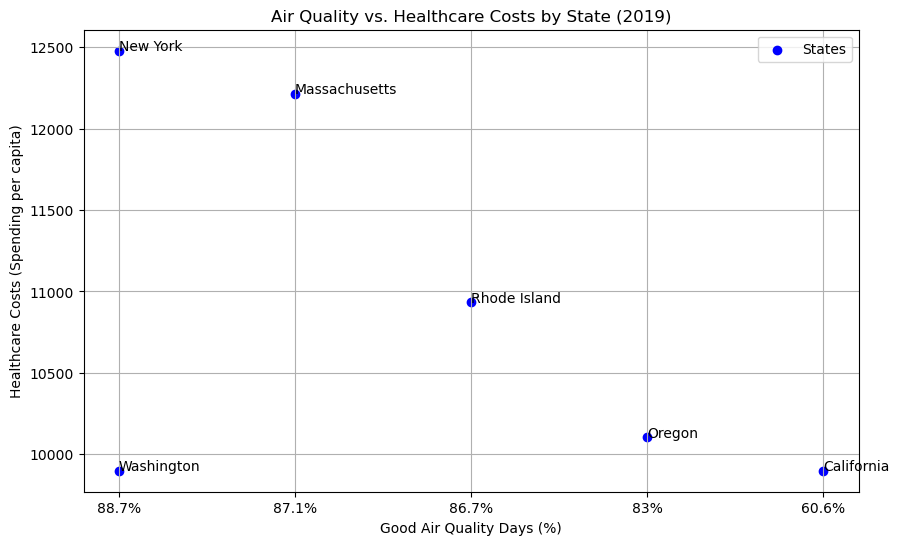

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# load csv into df
aqi_df = pd.read_csv("air_quality_data.csv")
spending_df = pd.read_csv("health_spendings.csv")

# clean df
states = ['Massachusetts', 'Rhode Island', 'New York', 'California', 'Washington', 'Oregon']
clean_aqi = aqi_df[aqi_df['State'].isin(states)]
clean_spending= spending_df[(spending_df['metric'] == 'Spending per capita') & (spending_df['subgroup'] == 'Total')
                                       & (spending_df['year'] == 2019) & (spending_df['state'].isin(states))]

# combine df
combine_df = pd.merge(clean_aqi, clean_spending, left_on = 'State', right_on = 'state', how = 'inner')

# create plot
plt.figure(figsize=(10, 6))
plt.scatter(combine_df['Good Air Quality Days'], combine_df['val'], label = 'States', color = 'blue')
for i, state in enumerate(combine_df['State']):
    plt.annotate(state, (combine_df['Good Air Quality Days'].iloc[i], combine_df['val'].iloc[i]))
plt.xlabel('Good Air Quality Days (%)')
plt.ylabel('Healthcare Costs (Spending per capita)')
plt.title('Air Quality vs. Healthcare Costs by State (2019)')
plt.grid(True)
plt.legend()
plt.show()

#### Average COPD Prevalence by State Histograme

Text(0.5, 1.0, 'Average COPD Prevalence by State')

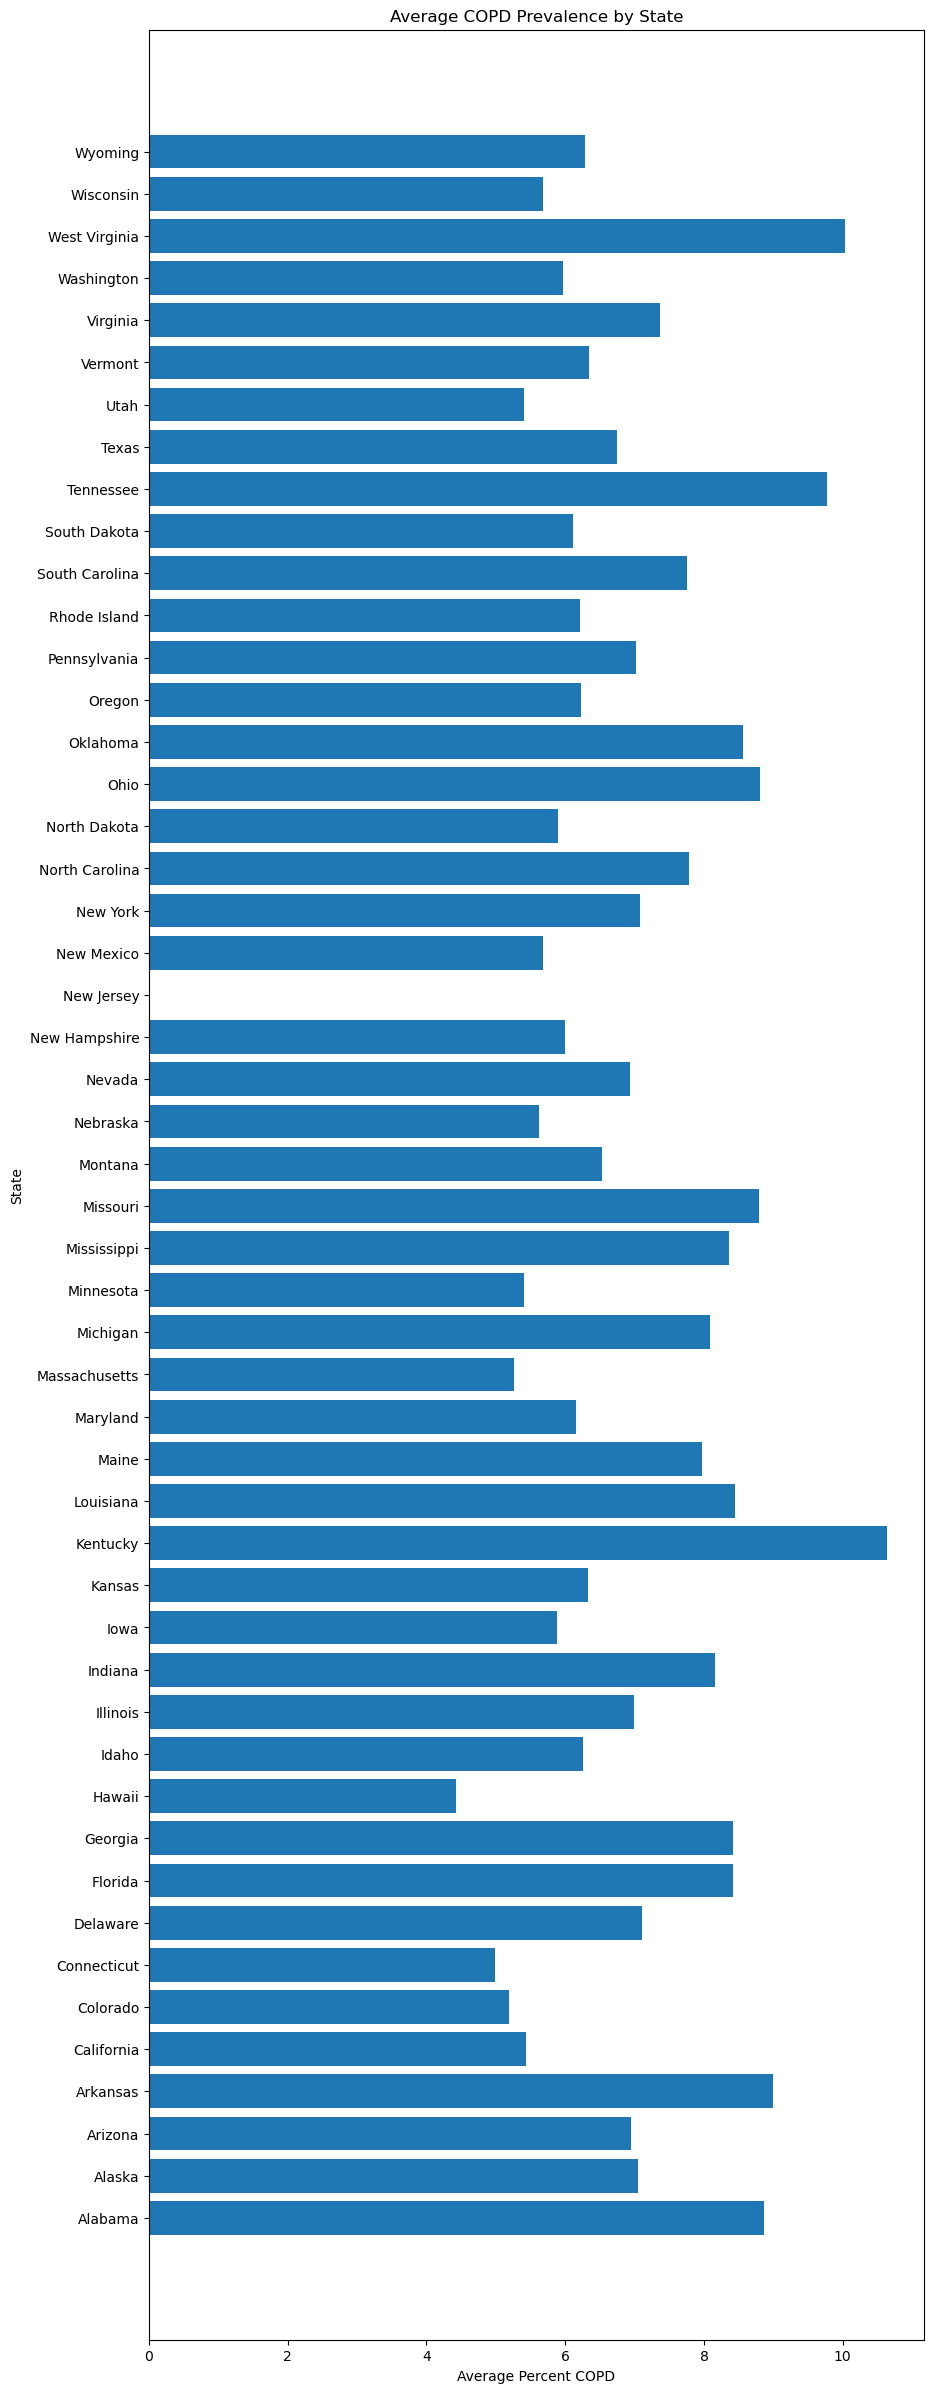

In [12]:
import matplotlib.pyplot as plt

# create histograme
csv = 'County_COPD_prevalence.csv'
df = csv_copd(csv)

plt.figure(figsize=(10, 30))
plt.barh(df['State'], df['Average_Percent_COPD'])
plt.xlabel('Average Percent COPD')
plt.ylabel('State')
plt.title('Average COPD Prevalence by State')

## Methods and Results

## Machine Learning

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pylab as py

In [14]:
def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)

### Predict Prevalence of COPD Using Multiple Linear Regression

#### Cross Validate: single-fold cross validation with a 70-30 split

In [15]:
# create arrays for X and y, scale X features
X = merged_df[['Good AQ Days', 'Moderate AQ Days', 'Unhealthy AQ Days']]
X = (X / X.std()).to_numpy()
y = merged_df['Average_COPD']

# cross validate
crossval = train_test_split(X, y, test_size = 0.3)
Xtrain, Xtest, ytrain, ytest = crossval

# fit model with test and training sets
regress_cv = LinearRegression()
regress_cv.fit(Xtrain, ytrain)
ypred_cv = regress_cv.predict(Xtest)

# get residuals, mse, and r^2
residuals_cv = ytest - ypred_cv
mse_cv = get_mse(ytest, ypred_cv)
r2_cv = r2_score(ytest, ypred_cv)

In [16]:
print(f'MSE: {mse_cv}')
print(f'R^2: {r2_cv}')

MSE: 0.00025312769362878973
R^2: 0.022151267652719464


#### Fit the Full Model with our Data

In [36]:
# create arrays for X and y, scale X features
X = merged_df[['Good AQ Days', 'Moderate AQ Days', 'Unhealthy AQ Days']]
X = (X / X.std()).to_numpy()
y = merged_df['Average_COPD']

# fit model with full data
regress = LinearRegression()
regress.fit(X, y)
ypred = regress.predict(X)

# get coefficients and intercept
coefficients = regress.coef_
intercept = regress.intercept_

# get residuals
residuals = y - ypred

In [37]:
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

Coefficients: [-0.10038171 -0.07904603 -0.03304354]
Intercept: 1.5079020857505896


#### Check Assumptions

Text(0.5, 1.0, 'index vs. residuals')

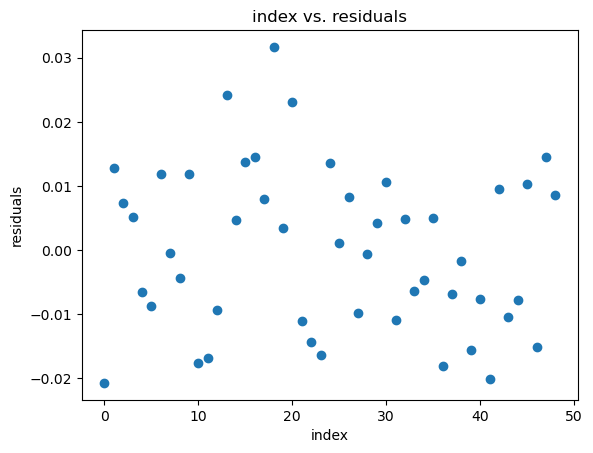

In [19]:
# independence
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('index')
plt.ylabel('residuals')
plt.title('index vs. residuals')

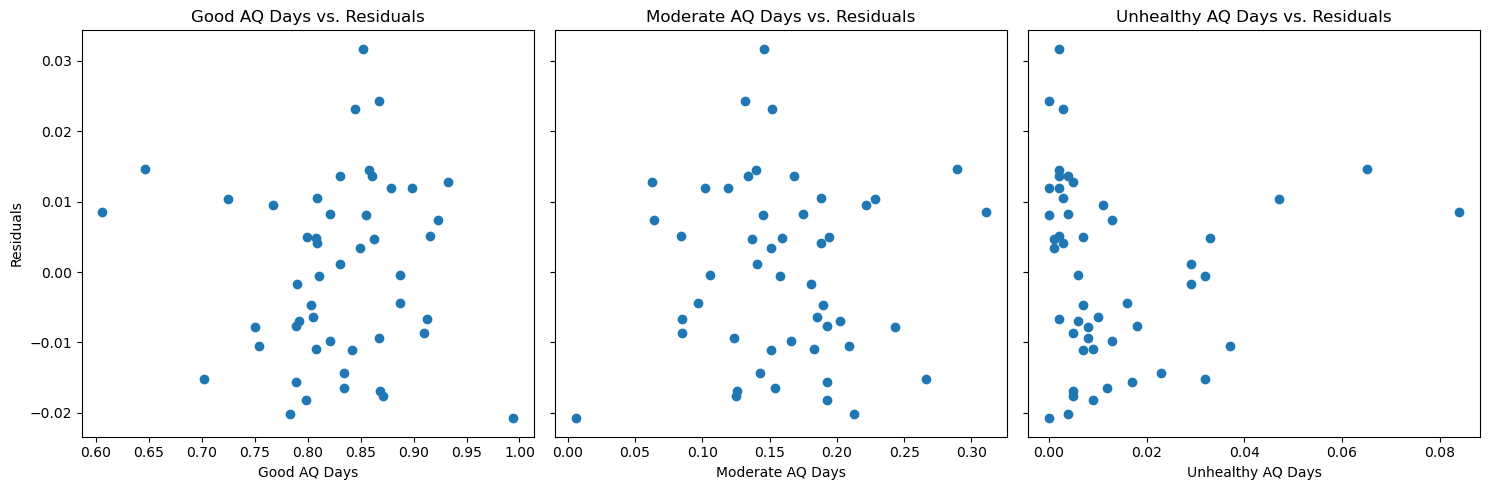

In [20]:
# check for constant variance
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

# good aq days
x_good = np.array(merged_df['Good AQ Days'])
axs[0].scatter(x_good, residuals)
axs[0].set_xlabel('Good AQ Days')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Good AQ Days vs. Residuals')

# moderate aq days
x_moderate = np.array(merged_df['Moderate AQ Days'])
axs[1].scatter(x_moderate, residuals)
axs[1].set_xlabel('Moderate AQ Days')
axs[1].set_title('Moderate AQ Days vs. Residuals')

# unhealthy aq days
x_unhealthy = np.array(merged_df['Unhealthy AQ Days'])
axs[2].scatter(x_unhealthy, residuals)
axs[2].set_xlabel('Unhealthy AQ Days')
axs[2].set_title('Unhealthy AQ Days vs. Residuals')

plt.tight_layout()
plt.show()

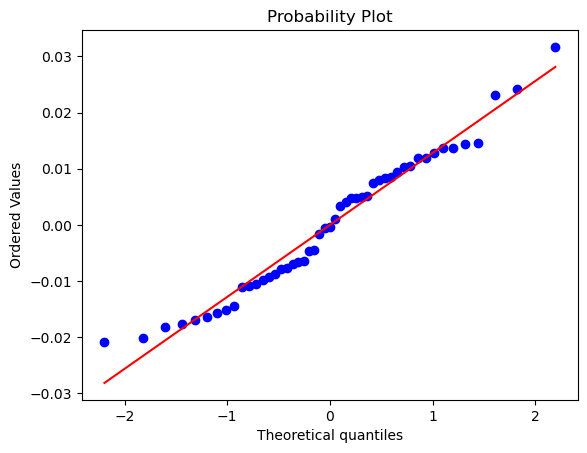

In [21]:
# QQ plot of residuals
stats.probplot(residuals, dist = "norm", plot = py)
py.show()

#### Transform y Feature - see if it helps pass constant variance

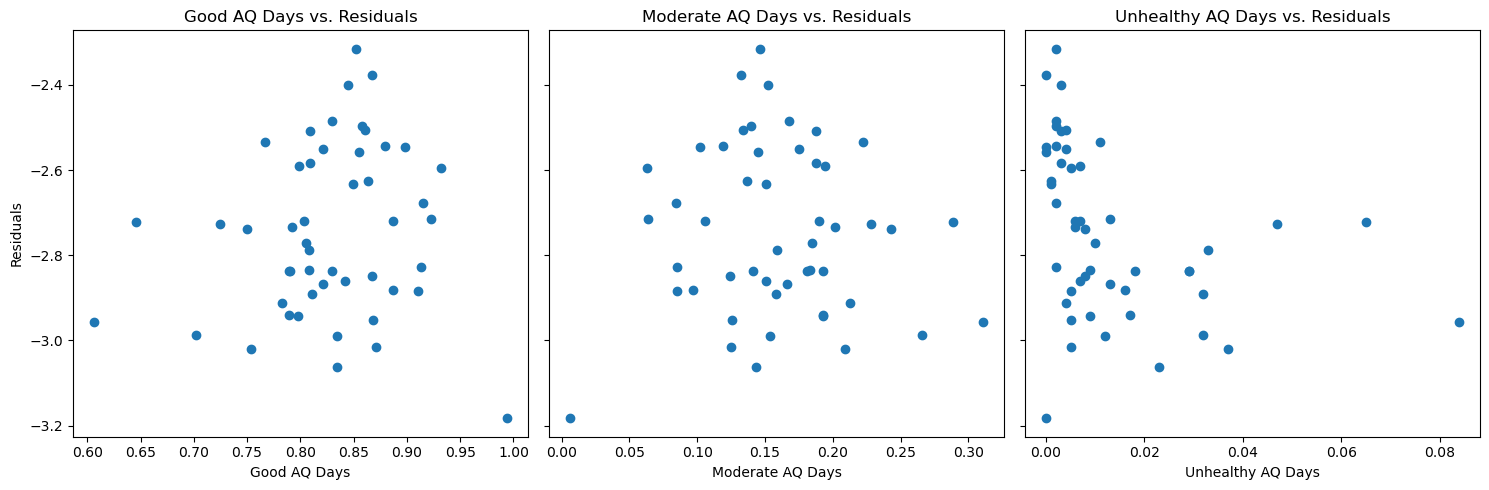

In [22]:
# log transformation
y_log = np.log(y)
residuals = y_log - ypred

# check for constant variance
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

# good aq days
x_good = np.array(merged_df['Good AQ Days'])
axs[0].scatter(x_good, residuals)
axs[0].set_xlabel('Good AQ Days')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Good AQ Days vs. Residuals')

# moderate aq days
x_moderate = np.array(merged_df['Moderate AQ Days'])
axs[1].scatter(x_moderate, residuals)
axs[1].set_xlabel('Moderate AQ Days')
axs[1].set_title('Moderate AQ Days vs. Residuals')

# unhealthy aq days
x_unhealthy = np.array(merged_df['Unhealthy AQ Days'])
axs[2].scatter(x_unhealthy, residuals)
axs[2].set_xlabel('Unhealthy AQ Days')
axs[2].set_title('Unhealthy AQ Days vs. Residuals')

plt.tight_layout()
plt.show()

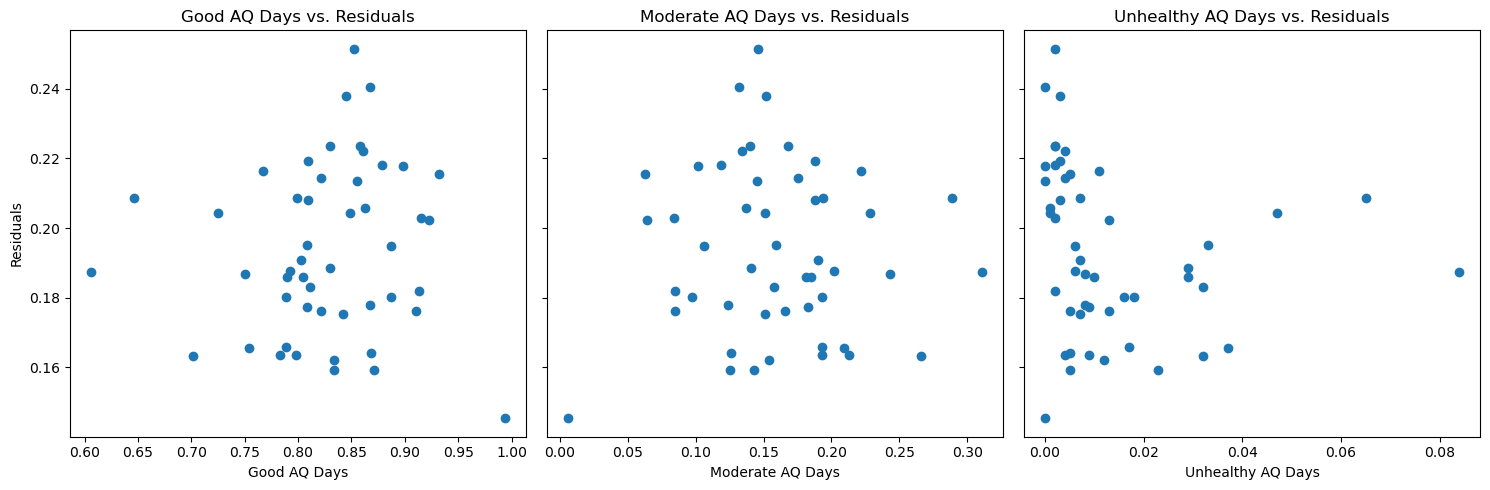

In [23]:
# square root transformation
y_sqrt = np.sqrt(y)
residuals = y_sqrt - ypred

# check for constant variance
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

# good aq days
x_good = np.array(merged_df['Good AQ Days'])
axs[0].scatter(x_good, residuals)
axs[0].set_xlabel('Good AQ Days')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Good AQ Days vs. Residuals')

# moderate aq days
x_moderate = np.array(merged_df['Moderate AQ Days'])
axs[1].scatter(x_moderate, residuals)
axs[1].set_xlabel('Moderate AQ Days')
axs[1].set_title('Moderate AQ Days vs. Residuals')

# unhealthy aq days
x_unhealthy = np.array(merged_df['Unhealthy AQ Days'])
axs[2].scatter(x_unhealthy, residuals)
axs[2].set_xlabel('Unhealthy AQ Days')
axs[2].set_title('Unhealthy AQ Days vs. Residuals')

plt.tight_layout()
plt.show()

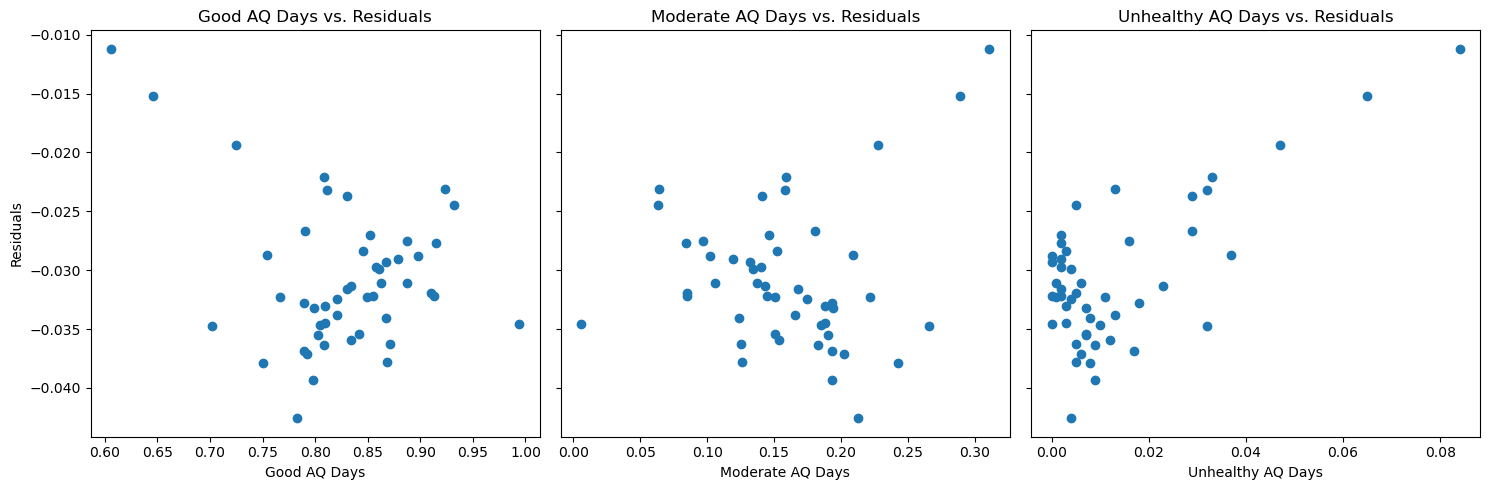

In [24]:
# boxcox transformation
from scipy.stats import boxcox

y_boxcox, _ = boxcox(y + 1)
residuals = y_boxcox - ypred

# check for constant variance
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

# good aq days
x_good = np.array(merged_df['Good AQ Days'])
axs[0].scatter(x_good, residuals)
axs[0].set_xlabel('Good AQ Days')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Good AQ Days vs. Residuals')

# moderate aq days
x_moderate = np.array(merged_df['Moderate AQ Days'])
axs[1].scatter(x_moderate, residuals)
axs[1].set_xlabel('Moderate AQ Days')
axs[1].set_title('Moderate AQ Days vs. Residuals')

# unhealthy aq days
x_unhealthy = np.array(merged_df['Unhealthy AQ Days'])
axs[2].scatter(x_unhealthy, residuals)
axs[2].set_xlabel('Unhealthy AQ Days')
axs[2].set_title('Unhealthy AQ Days vs. Residuals')

plt.tight_layout()
plt.show()

### Predict Health Spendings using Multiple Linear Regression

#### Cross Validate: single-fold cross validation with a 70-30 split

In [25]:
# create arrays for X and y, scale X features
X = merged_df[['Good AQ Days', 'Moderate AQ Days', 'Unhealthy AQ Days']]
X = (X / X.std()).to_numpy()
y = merged_df['Health Spendings ($)']

# cross validate
crossval = train_test_split(X, y, test_size = 0.3)
Xtrain, Xtest, ytrain, ytest = crossval

# fit model with test and training sets
regress_cv = LinearRegression()
regress_cv.fit(Xtrain, ytrain)
ypred_cv = regress_cv.predict(Xtest)

# get residuals, mse, and r^2
residuals_cv = ytest - ypred_cv
mse_cv = get_mse(ytest, ypred_cv)
r2_cv = r2_score(ytest, ypred_cv)

In [26]:
print(f'MSE: {mse_cv}')
print(f'R^2: {r2_cv}')

MSE: 2522751.3325074445
R^2: 0.22710698506972626


#### Fit the Full Model with our Data

In [38]:
# create arrays for X and y, scale X features
X = merged_df[['Good AQ Days', 'Moderate AQ Days', 'Unhealthy AQ Days']]
X = (X / X.std()).to_numpy()
y = merged_df['Health Spendings ($)']

# fit model with full data
regress = LinearRegression()
regress.fit(X, y)
ypred = regress.predict(X)

# get coefficients and intercept
coefficients = regress.coef_
intercept = regress.intercept_

# get residuals
residuals = y - ypred

In [39]:
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

Coefficients: [-8393.0593728  -7655.85828917 -1924.52815207]
Intercept: 132584.2790613413


#### Check Assumptions

Text(0.5, 1.0, 'index vs. residuals')

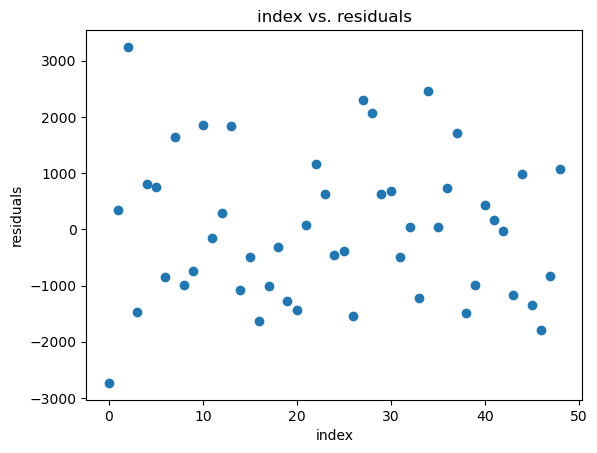

In [29]:
# independence
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('index')
plt.ylabel('residuals')
plt.title('index vs. residuals')

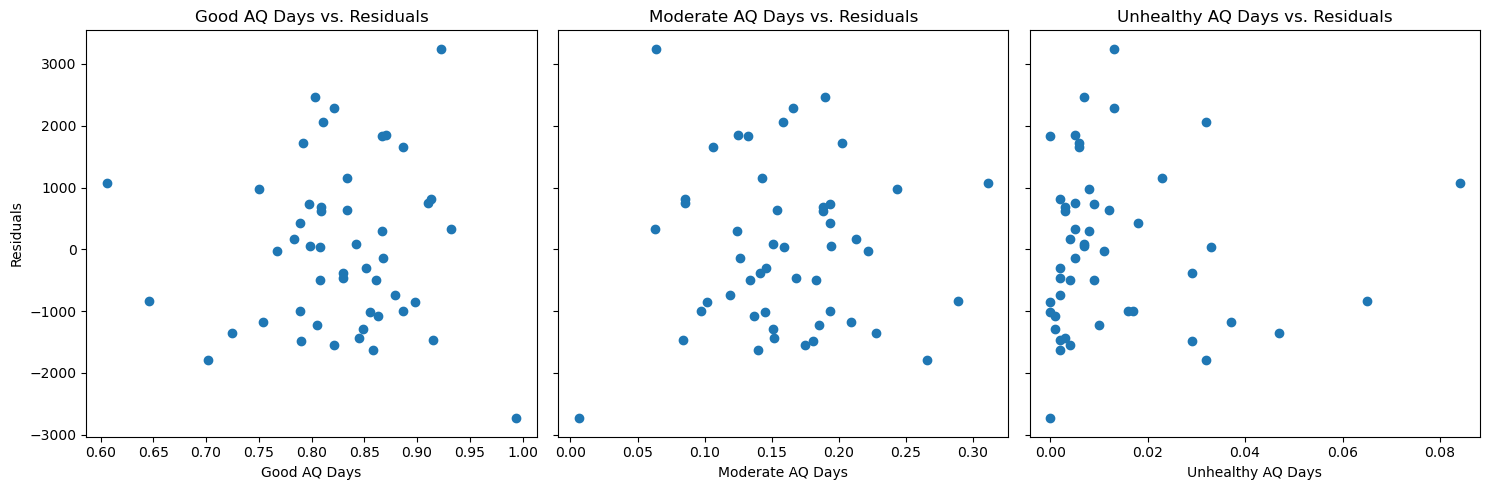

In [30]:
# check for constant variance
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

# good aq days
x_good = np.array(merged_df['Good AQ Days'])
axs[0].scatter(x_good, residuals)
axs[0].set_xlabel('Good AQ Days')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Good AQ Days vs. Residuals')

# moderate aq days
x_moderate = np.array(merged_df['Moderate AQ Days'])
axs[1].scatter(x_moderate, residuals)
axs[1].set_xlabel('Moderate AQ Days')
axs[1].set_title('Moderate AQ Days vs. Residuals')

# unhealthy aq days
x_unhealthy = np.array(merged_df['Unhealthy AQ Days'])
axs[2].scatter(x_unhealthy, residuals)
axs[2].set_xlabel('Unhealthy AQ Days')
axs[2].set_title('Unhealthy AQ Days vs. Residuals')

plt.tight_layout()
plt.show()

# i don't think it really passes constant variance, idk if we wanna try a new model,
# or just talk about it in the discussion?

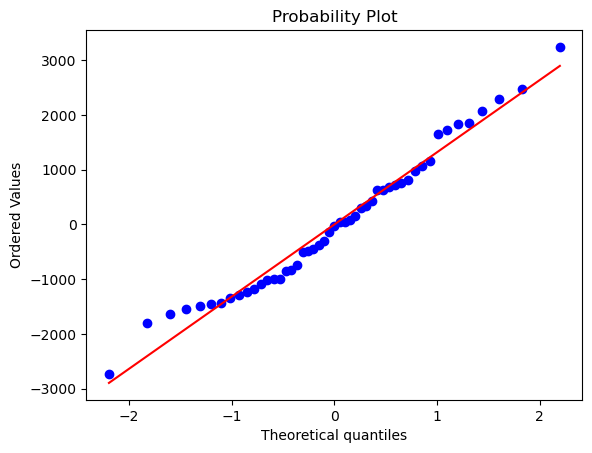

In [31]:
# QQ plot of residuals
stats.probplot(residuals, dist = "norm", plot = py)
py.show()

#### Tranform y - see if it helps pass constant variance

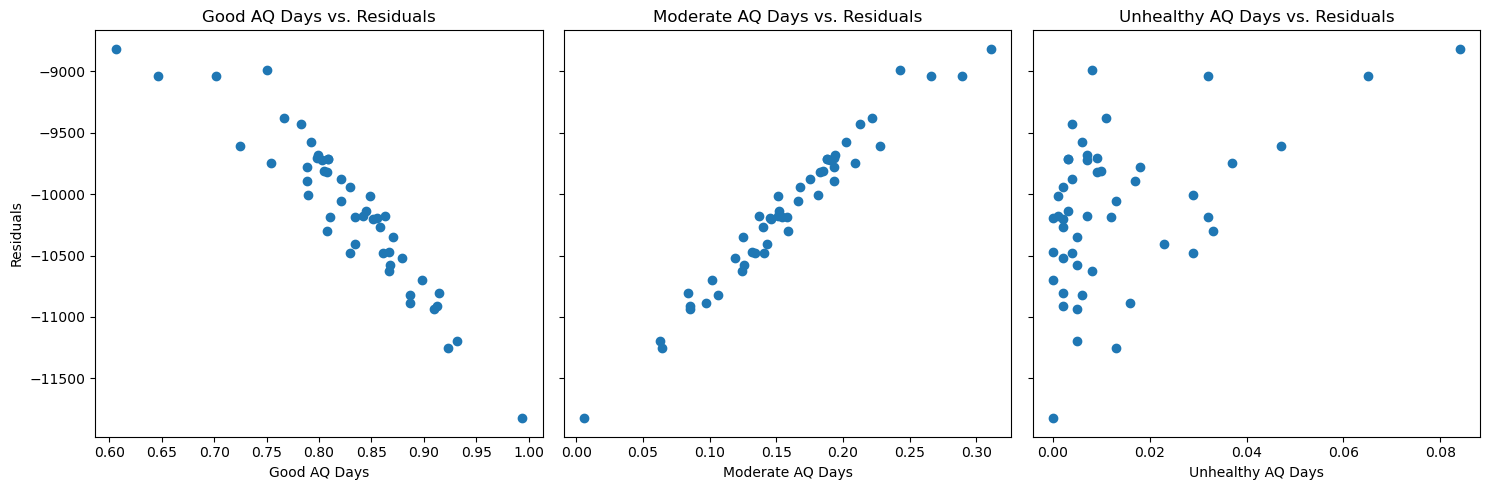

In [32]:
# log transformation
y_log = np.log(y)
residuals = y_log - ypred

# check for constant variance
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

# good aq days
x_good = np.array(merged_df['Good AQ Days'])
axs[0].scatter(x_good, residuals)
axs[0].set_xlabel('Good AQ Days')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Good AQ Days vs. Residuals')

# moderate aq days
x_moderate = np.array(merged_df['Moderate AQ Days'])
axs[1].scatter(x_moderate, residuals)
axs[1].set_xlabel('Moderate AQ Days')
axs[1].set_title('Moderate AQ Days vs. Residuals')

# unhealthy aq days
x_unhealthy = np.array(merged_df['Unhealthy AQ Days'])
axs[2].scatter(x_unhealthy, residuals)
axs[2].set_xlabel('Unhealthy AQ Days')
axs[2].set_title('Unhealthy AQ Days vs. Residuals')

plt.tight_layout()
plt.show()

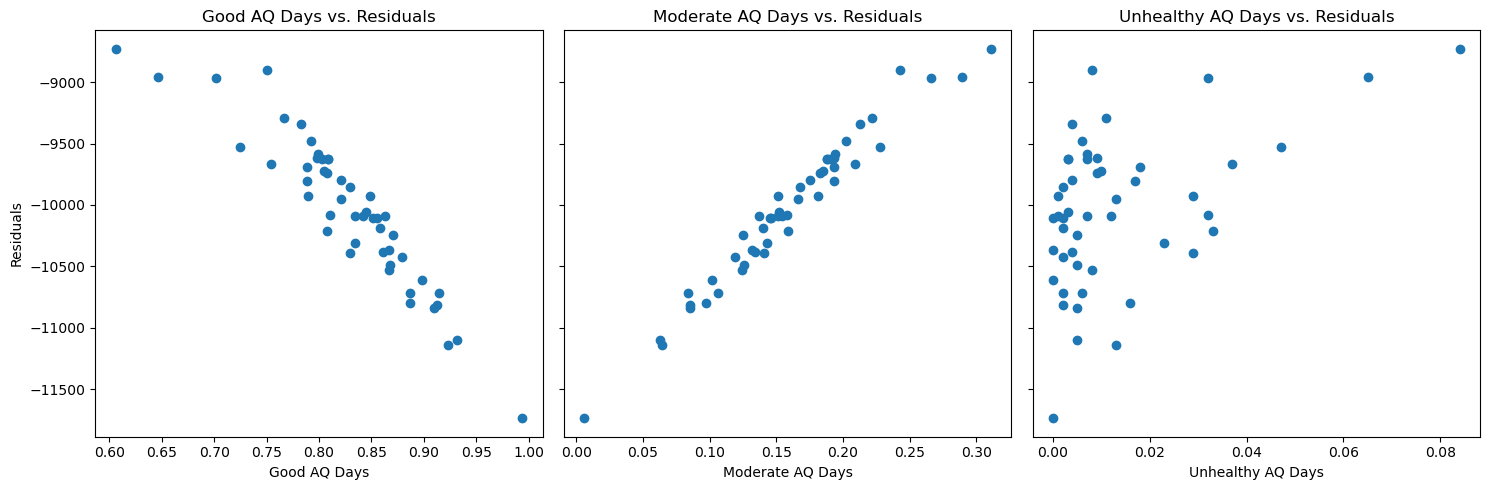

In [33]:
# square root transformation
y_sqrt = np.sqrt(y)
residuals = y_sqrt - ypred

# check for constant variance
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

# good aq days
x_good = np.array(merged_df['Good AQ Days'])
axs[0].scatter(x_good, residuals)
axs[0].set_xlabel('Good AQ Days')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Good AQ Days vs. Residuals')

# moderate aq days
x_moderate = np.array(merged_df['Moderate AQ Days'])
axs[1].scatter(x_moderate, residuals)
axs[1].set_xlabel('Moderate AQ Days')
axs[1].set_title('Moderate AQ Days vs. Residuals')

# unhealthy aq days
x_unhealthy = np.array(merged_df['Unhealthy AQ Days'])
axs[2].scatter(x_unhealthy, residuals)
axs[2].set_xlabel('Unhealthy AQ Days')
axs[2].set_title('Unhealthy AQ Days vs. Residuals')

plt.tight_layout()
plt.show()

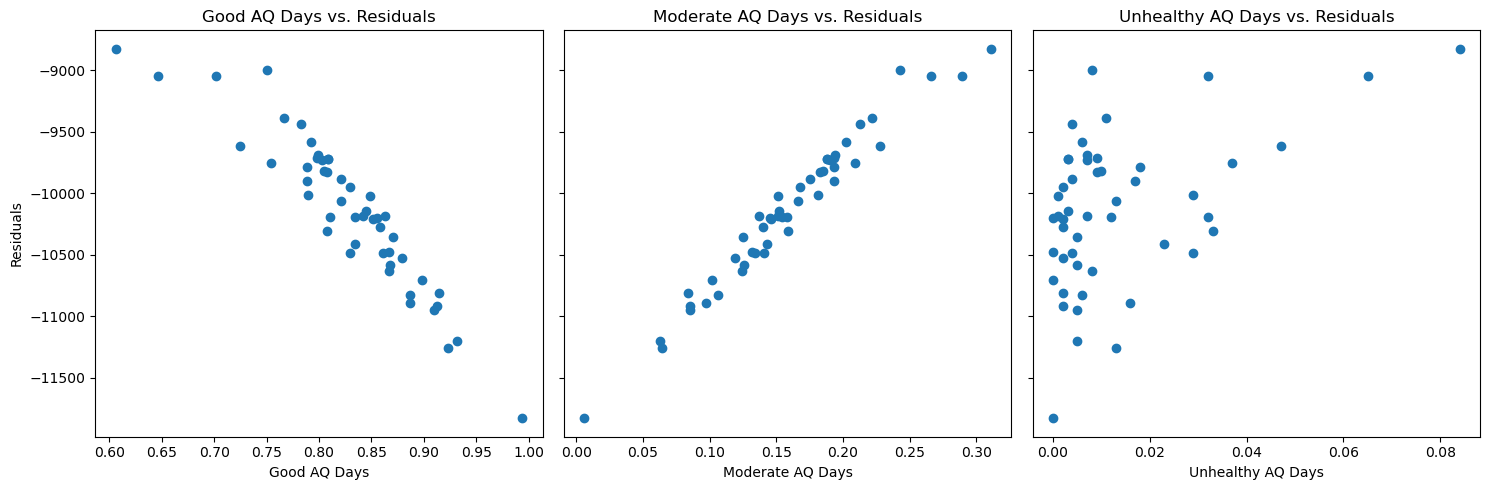

In [34]:
# boxcox transformation
from scipy.stats import boxcox

y_boxcox, _ = boxcox(y + 1)
residuals = y_boxcox - ypred

# check for constant variance
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

# good aq days
x_good = np.array(merged_df['Good AQ Days'])
axs[0].scatter(x_good, residuals)
axs[0].set_xlabel('Good AQ Days')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Good AQ Days vs. Residuals')

# moderate aq days
x_moderate = np.array(merged_df['Moderate AQ Days'])
axs[1].scatter(x_moderate, residuals)
axs[1].set_xlabel('Moderate AQ Days')
axs[1].set_title('Moderate AQ Days vs. Residuals')

# unhealthy aq days
x_unhealthy = np.array(merged_df['Unhealthy AQ Days'])
axs[2].scatter(x_unhealthy, residuals)
axs[2].set_xlabel('Unhealthy AQ Days')
axs[2].set_title('Unhealthy AQ Days vs. Residuals')

plt.tight_layout()
plt.show()


## Discussion

- We used multiple linear regression analysis to investigate the associations between air quality metrics and public health indicators, namely COPD prevalence and healthcare costs. We aimed to determine how the percentages of good, moderate, and unhealthy air quality days relate to these important health outcomes.  
- From our regression model to predict health spendings, the coefficients show that states with better air quality may spend less on healthcare. However, these correlations are also moderate in strength, implying that there are other variables that influence healthcare spending, which we did not account for in our analysis.
- We evaluated the assumption of constant variance by plotting the residuals against the predictor variables. However, some of the features had not passed the constant variance assumption. We attempted to transform the response variable (percentage of COPD and healthcare spendings) using log, squareroot, and boxcox transformations to address issues related to the assumption of constant variance in the linear regression model, so the variability of the residuals (the differences between the observed and predicted values) should have remained constant across all levels of the predictors. Despite doing this, the constant variance assumption was not fully met.  
- In the future we could try out different models instead, such as a polynomial or logistic regression model. With polynomial regression, we could extend the linear regression by including polynomial terms to capture nonlinear relationships, the advantage to this model being that it can handle curved relationships between predictors and the response variable. Other models that could also be used in the future that we hadn’t explored in class are Naive Bayes and RandomForests.
- We could also try using other public health indicators to predict using air quality days, such as asthma or cancer. We could also use other air quality metrics, such as the levels of different pollutants, to predict COPD and health spendings.

 Challenges:
- Challenges in meeting the constant variance assumption prompted consideration of alternative models.

Future Directions:
- Proposing exploration of polynomial regression for non-linear relationships
- Explore Naive Bayes and Random Forest models

Conclusion:

While our study sheds light on associations, we acknowledge the importance of trying other modeling approaches for a better grasp of these complex relationships.
